In [1]:
import os

import torch
from torch.utils.data import Dataset
import cv2


class SouthParkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.paths = []
        for dir, subdir, files in os.walk(self.root_dir):
            for file in files:
                self.paths.append(os.path.join(dir, file))

    @staticmethod
    def __read_img(path) -> torch.Tensor:
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        return image
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = self.__read_img(self.paths[idx])

        if self.transform:
            image = self.transform(image)

        return image

In [2]:
dataset = SouthParkDataset(root_dir="../single_character_data", transform=None)
len(dataset)

906

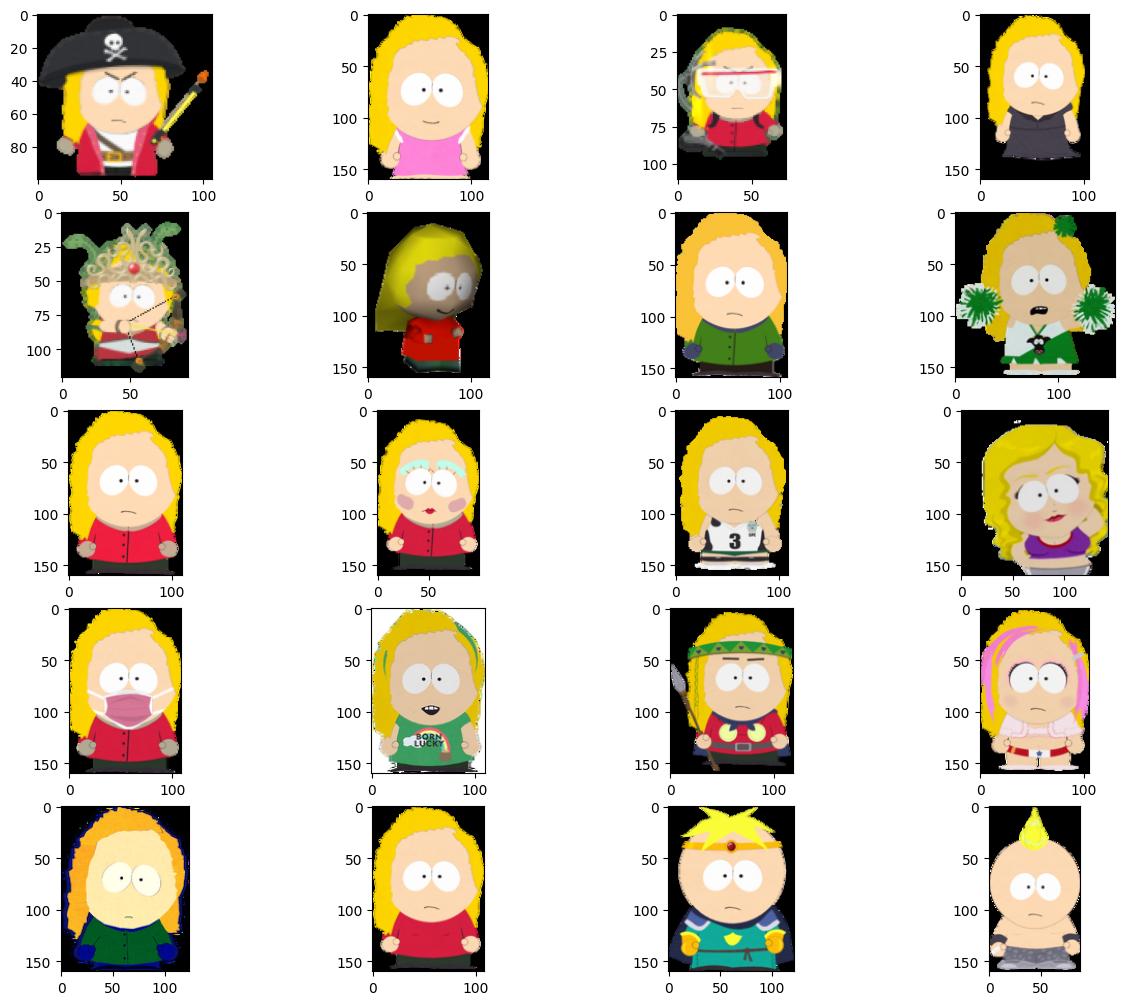

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt


def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)



show_images(dataset)

In [4]:
import torch.nn.functional as F

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 16


def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ])

    dataset = SouthParkDataset(root_dir="../single_character_data", transform=data_transforms)
    
    return dataset


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0]
        
    plt.imshow(reverse_transforms(image))

    
train_dataset = load_transformed_dataset()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


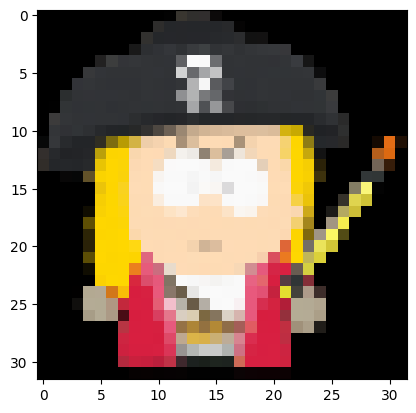

In [6]:
show_tensor_image(train_dataset[0])

In [7]:
!git clone https://github.com/openai/improved-diffusion
!mv improved-diffusion/improved_diffusion ./

fatal: destination path 'improved-diffusion' already exists and is not an empty directory.
mv: cannot stat 'improved-diffusion/improved_diffusion': No such file or directory


In [8]:
! pip install -e improved-diffusion

Obtaining file:///home/leffff/PycharmProjects/south-park-character-generation/models/improved-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: improved-diffusion
    Found existing installation: improved-diffusion 0.0.0
    Uninstalling improved-diffusion-0.0.0:
      Successfully uninstalled improved-diffusion-0.0.0
  Running setup.py develop for improved-diffusion

[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [9]:
from improved_diffusion.unet import UNetModel

model = UNetModel(
    in_channels=3, 
    model_channels=64, 
    out_channels=3,
    num_res_blocks=3, 
    attention_resolutions=("16",)
)
model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-3): 3 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection

# Ну вот вроде как наш лосс 

In [10]:
from torch.distributions.normal import Normal


def sde_loss(model, x_0, x_1, t, eps=1e-2):
    t = t.unsqueeze(1).unsqueeze(1).unsqueeze(1)
    x_t = Normal(loc=(t * x_1 + (1 - t) * x_0), scale=(eps * t * (1 - t) * torch.ones_like(x_1))).sample()
    t = t.flatten()
    noise_pred = model(x_t, t.squeeze())
    
    return F.mse_loss(noise_pred, (x_1 - x_t) / (1 - t.unsqueeze(1).unsqueeze(1).unsqueeze(1)), reduction="sum")

In [11]:
@torch.no_grad()
def euler_integration(net, x_0):
    model.eval()
    
    eps = 1e-8
    n_steps = 100
    t = torch.linspace(eps, 1 - eps, n_steps + 1).to(x_0.device)

    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(n_steps / num_images)

    for i in range(1, len(t)):
        t_prev = t[i - 1].unsqueeze(0)
        
        if i == n_steps:
          x_t = x_0 + (1 / n_steps) * model(x_0, t_prev)
        else:
          z_t = Normal(torch.zeros_like(x_0), torch.ones_like(x_0)).sample().to(device)
          x_t = x_0 + (1 / n_steps) * model(x_0, t_prev) + torch.sqrt(torch.tensor((eps / n_steps), dtype=torch.float32, device=device)) * z_t
          x_0 = x_t
    
        if i % stepsize == 0 or i == (len(t) - 1):
            plt.subplot(1, num_images, int(i / stepsize))
            show_tensor_image(x_0.detach().cpu())
            
    plt.show()


In [12]:
def train_epoch(model, dataloader, device):
    model.to(device)
    model.train()

    total_loss = 0.0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        t = torch.tensor(np.random.uniform(size=(BATCH_SIZE)), dtype=torch.float32).to(device)
        x_1 = batch.to(device)
        x_0 = torch.tensor(np.random.normal(size=list(x_1.size())), dtype=torch.float32).to(device)
        
        loss = sde_loss(model, x_0, x_1, t)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader.dataset)

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                                                                                                                                               | 0/56 [00:00<?, ?it/s]/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current defa

Epoch 0 | Train Loss: 3844.235690017936


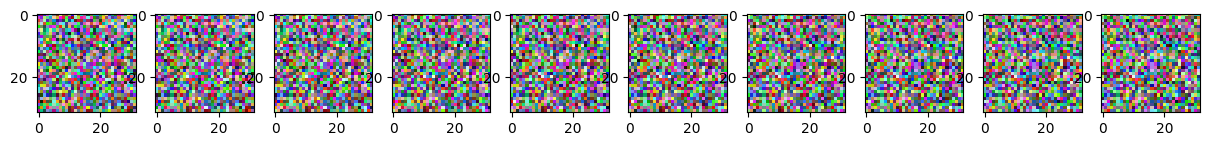

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.43it/s]


Epoch 1 | Train Loss: 2894.418589610927


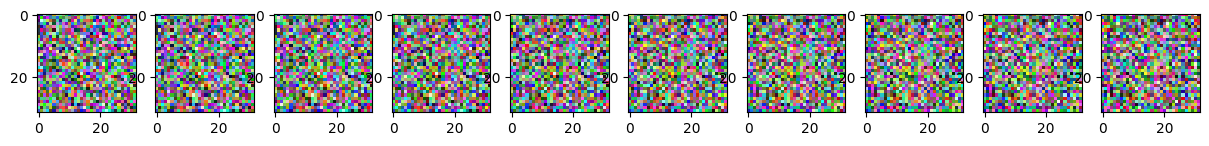

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.82it/s]


Epoch 2 | Train Loss: 2180.8550052600717


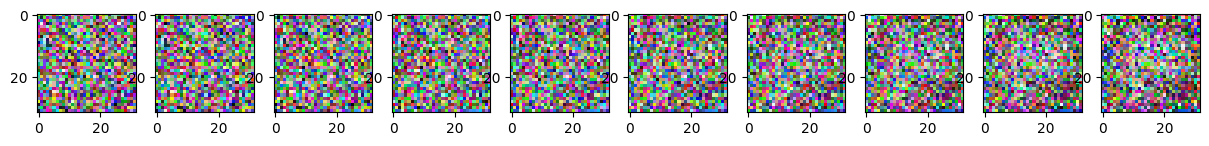

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.86it/s]


Epoch 3 | Train Loss: 1775.0805114341888


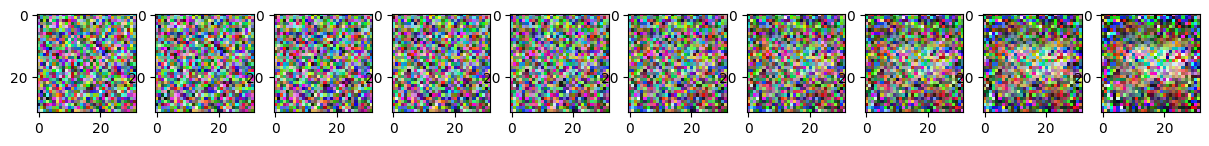

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.18it/s]


Epoch 4 | Train Loss: 1571.3657991859823


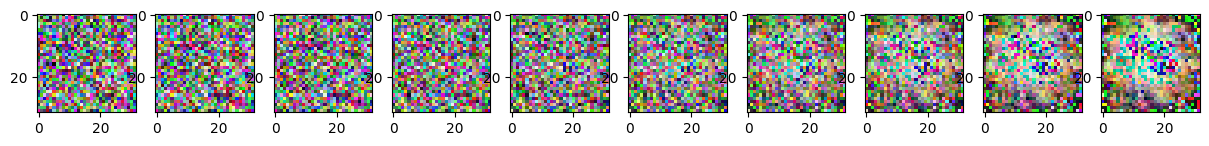

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.82it/s]


Epoch 5 | Train Loss: 1427.5439517798013


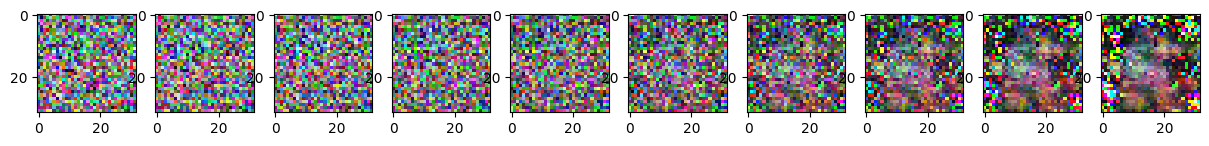

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.45it/s]


Epoch 6 | Train Loss: 1350.1281625103477


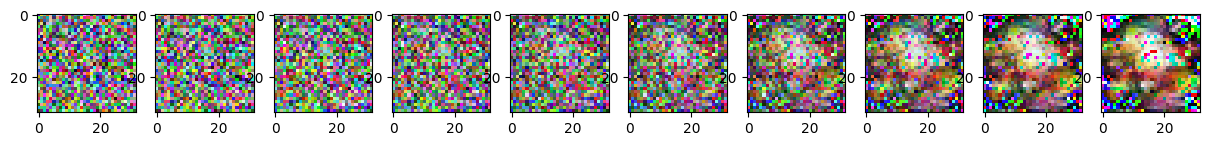

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.70it/s]


Epoch 7 | Train Loss: 1294.4683598061533


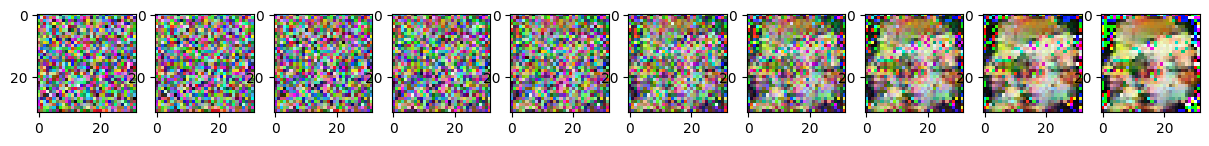

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.74it/s]


Epoch 8 | Train Loss: 1255.2421206712197


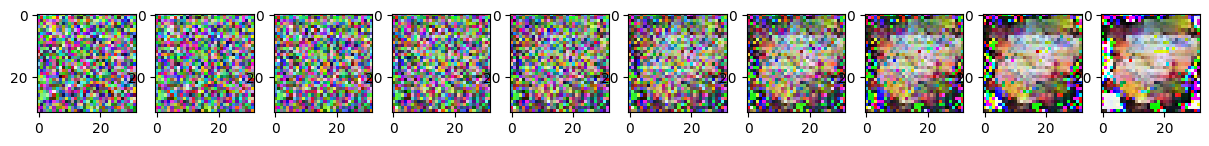

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.19it/s]


Epoch 9 | Train Loss: 1195.4146003638934


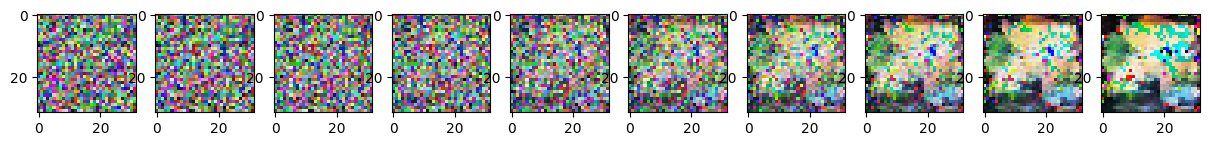

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.73it/s]


Epoch 10 | Train Loss: 1165.2057097647628


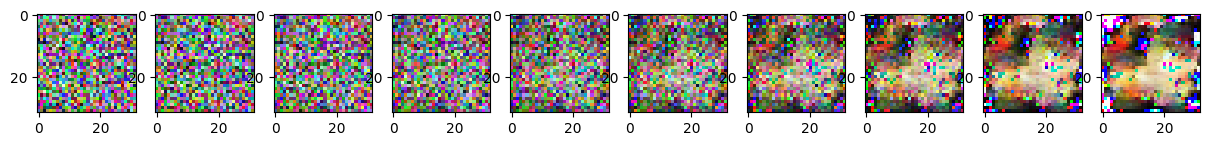

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.80it/s]


Epoch 11 | Train Loss: 1122.3997535958194


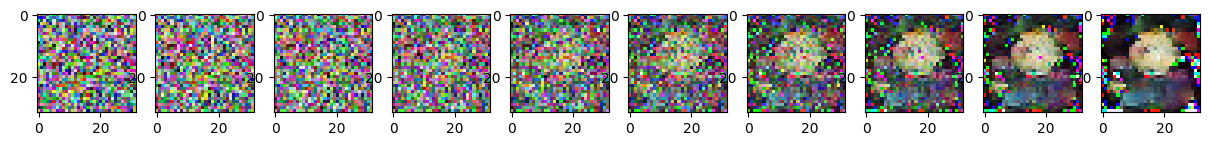

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 18.89it/s]


Epoch 12 | Train Loss: 1113.9840990618102


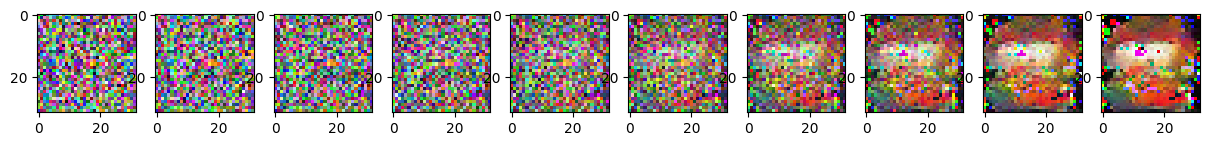

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.94it/s]


Epoch 13 | Train Loss: 1099.9495647506208


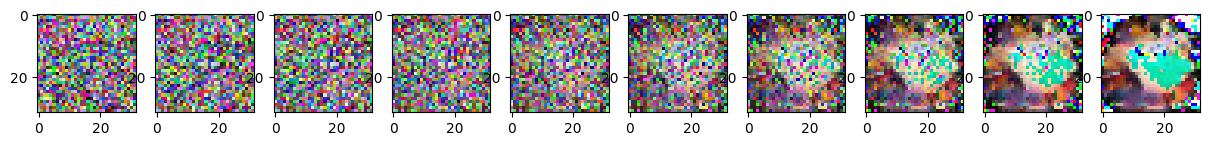

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.01it/s]


Epoch 14 | Train Loss: 1089.4463461903283


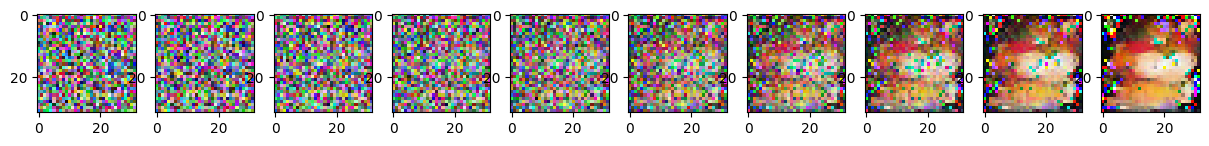

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.84it/s]


Epoch 15 | Train Loss: 1049.3209150369066


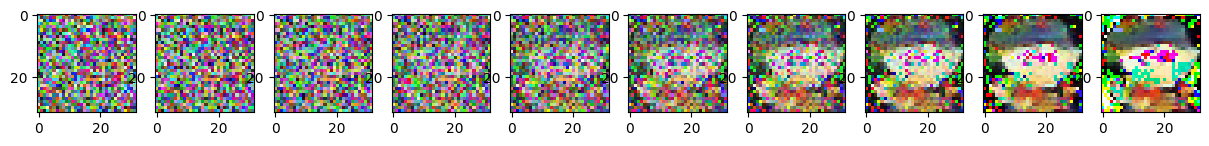

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.05it/s]


Epoch 16 | Train Loss: 1079.0616721854306


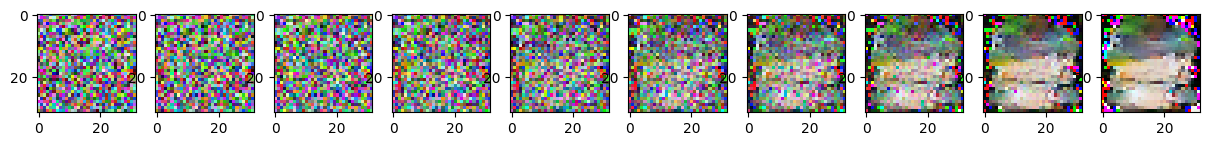

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.03it/s]


Epoch 17 | Train Loss: 1043.6041063051875


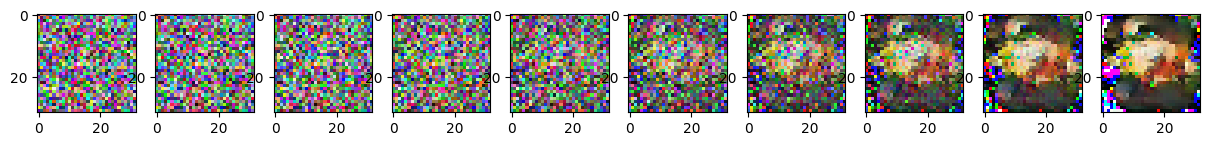

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.94it/s]


Epoch 18 | Train Loss: 1030.9045911372102


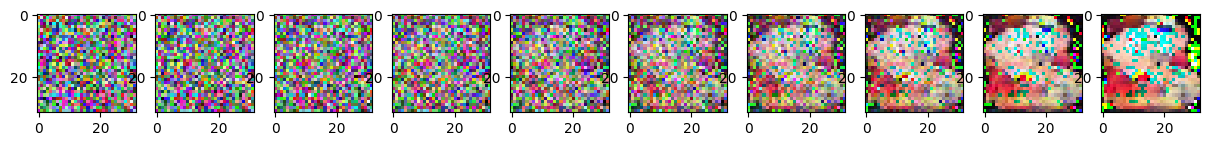

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 20.05it/s]


Epoch 19 | Train Loss: 1023.3738100165563


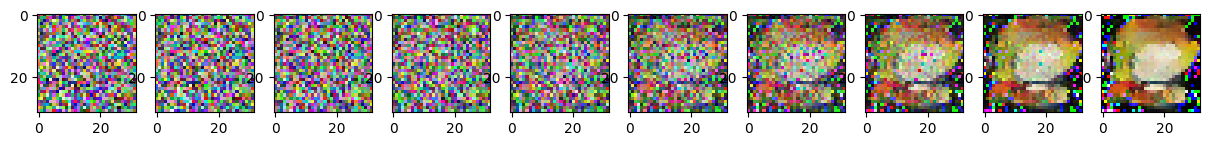

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.50it/s]


Epoch 20 | Train Loss: 1030.839904111479


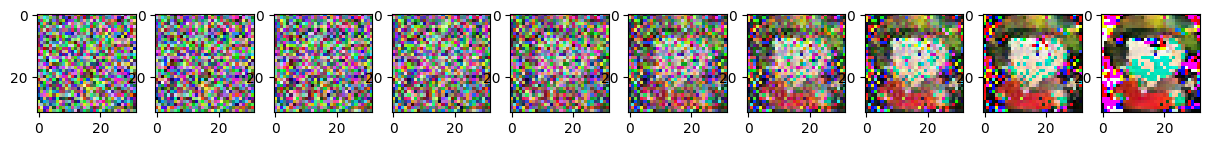

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 20.41it/s]


Epoch 21 | Train Loss: 990.8893498637556


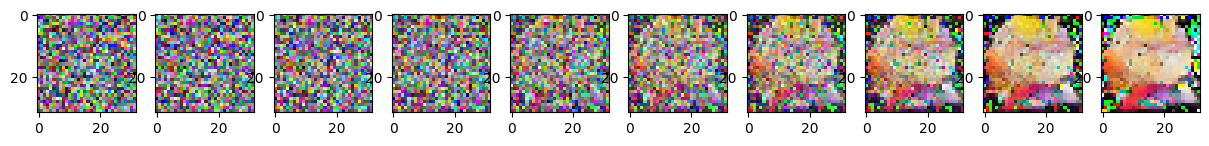

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.50it/s]


Epoch 22 | Train Loss: 975.8315753052566


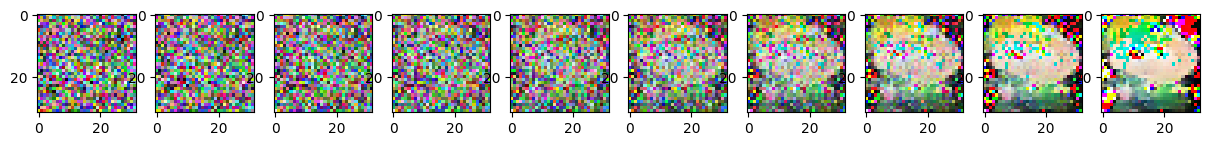

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 20.39it/s]


Epoch 23 | Train Loss: 994.7660863341612


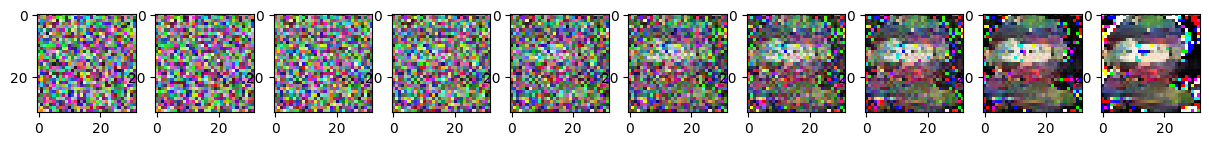

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.27it/s]


Epoch 24 | Train Loss: 999.5630594215646


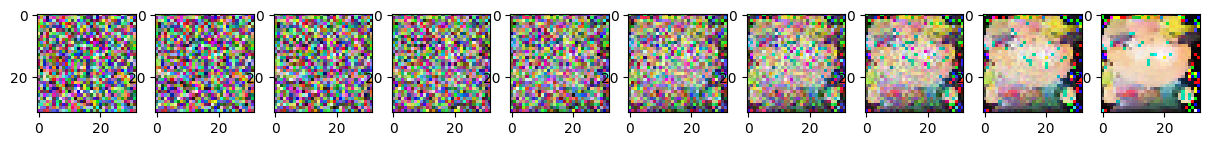

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.27it/s]


Epoch 25 | Train Loss: 949.9994481236203


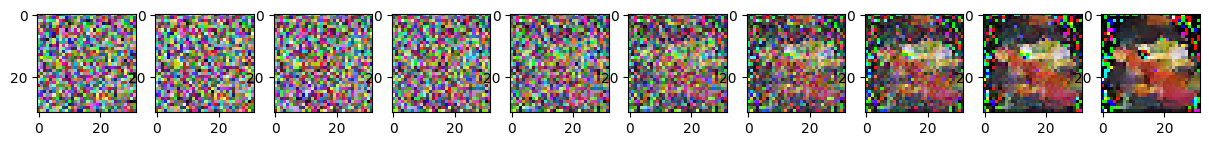

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 18.92it/s]


Epoch 26 | Train Loss: 944.8484021454194


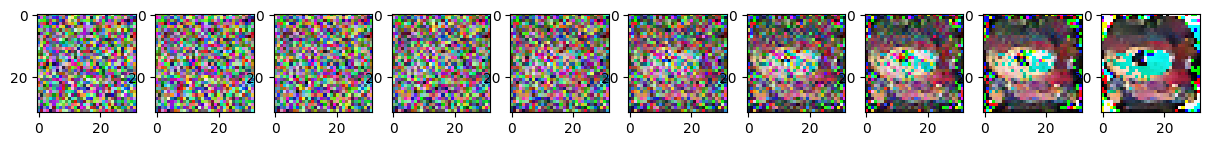

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.03it/s]


Epoch 27 | Train Loss: 954.5153921771523


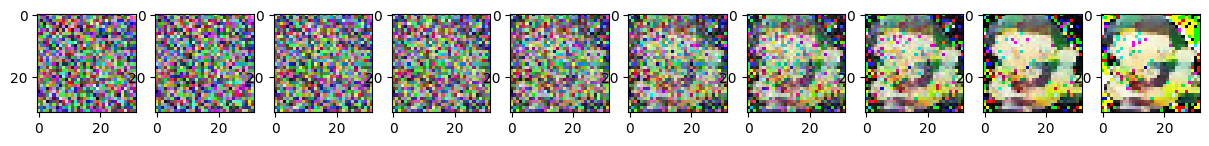

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.70it/s]


Epoch 28 | Train Loss: 932.4431351752207


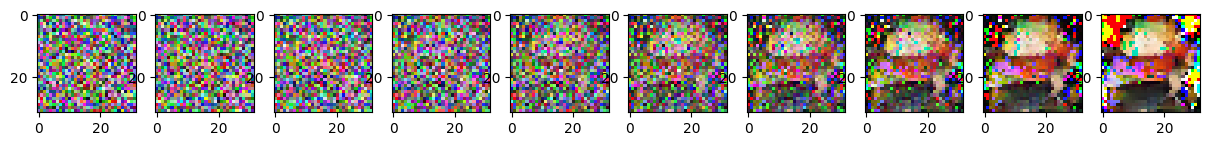

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.44it/s]


Epoch 29 | Train Loss: 923.6058546323123


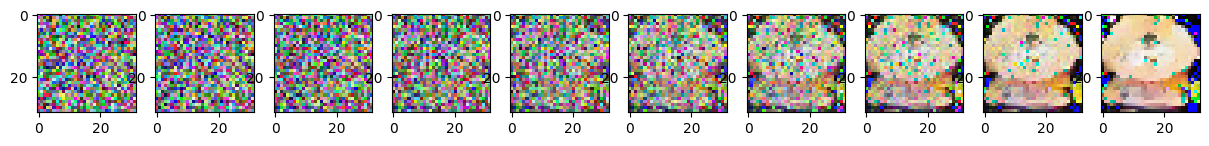

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 19.96it/s]


Epoch 30 | Train Loss: 925.8858338076021


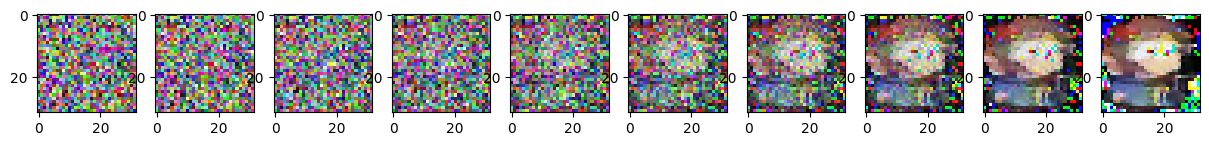

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.18it/s]


Epoch 31 | Train Loss: 942.144649817191


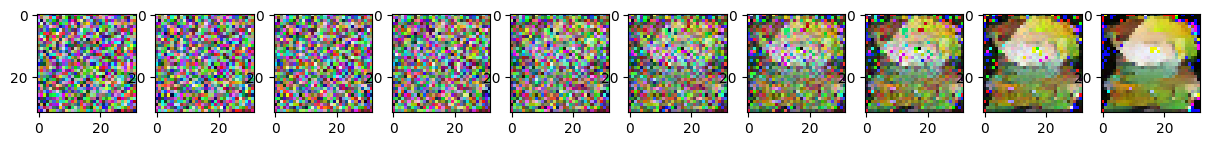

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 18.69it/s]


Epoch 32 | Train Loss: 922.1058427755933


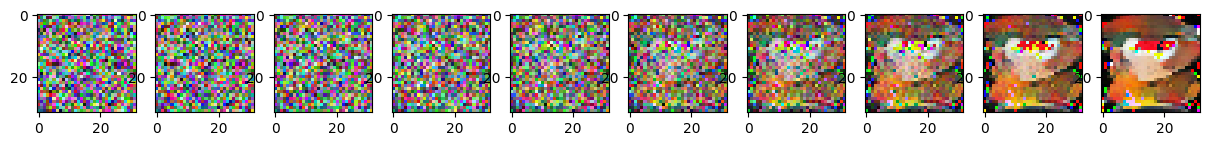

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.62it/s]


Epoch 33 | Train Loss: 895.844177919771


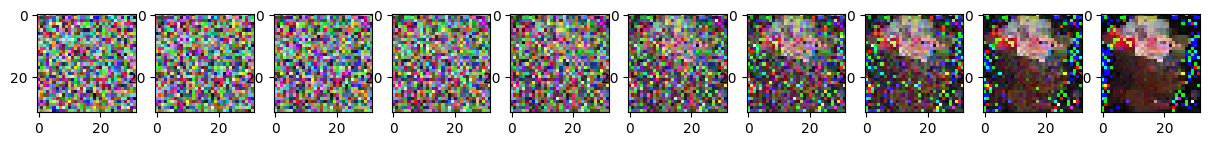

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 20.34it/s]


Epoch 34 | Train Loss: 926.8681252586921


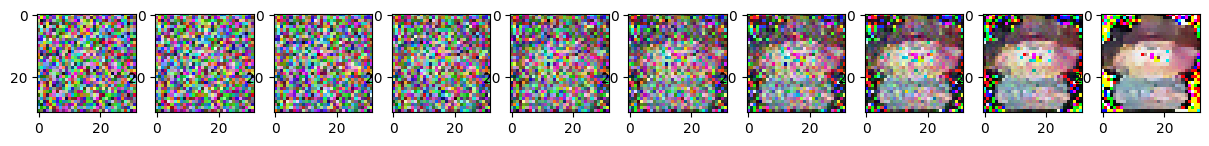

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 20.24it/s]


Epoch 35 | Train Loss: 896.4279768987997


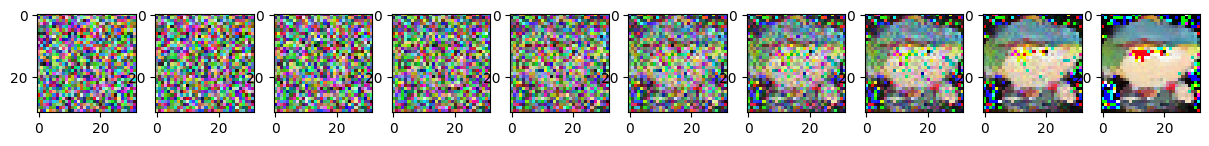

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 20.40it/s]


Epoch 36 | Train Loss: 924.7399099320502


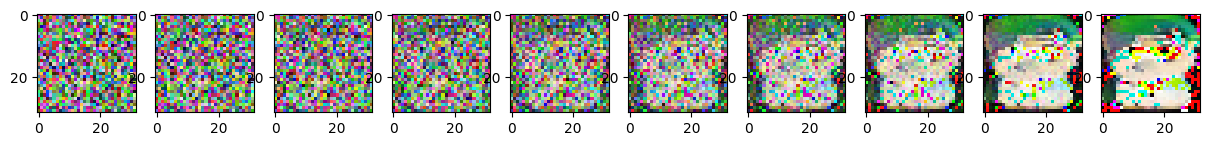

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.20it/s]


Epoch 37 | Train Loss: 900.0745302583472


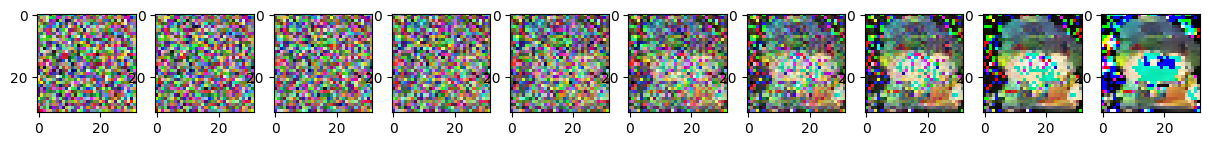

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.66it/s]


Epoch 38 | Train Loss: 889.7508741635623


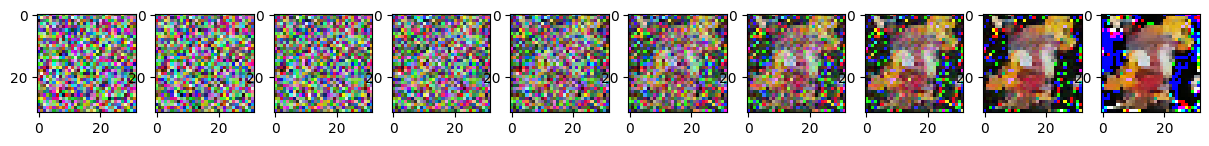

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.70it/s]


Epoch 39 | Train Loss: 913.9077072985651


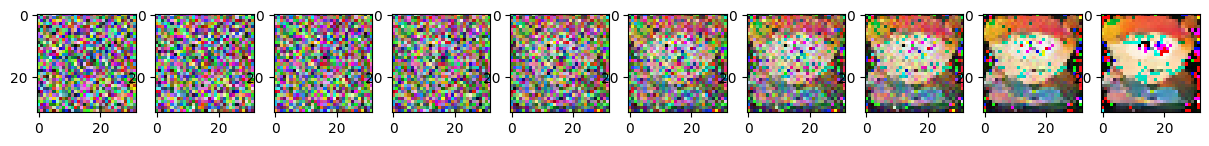

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.26it/s]


Epoch 40 | Train Loss: 896.780792977373


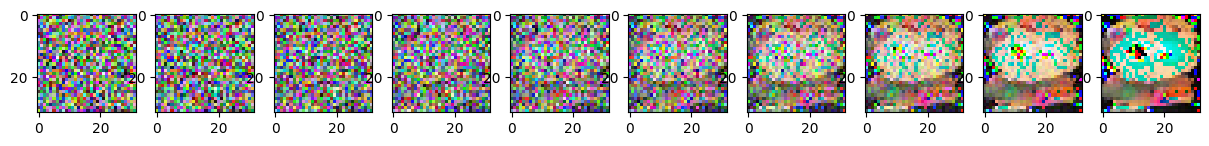

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.16it/s]


Epoch 41 | Train Loss: 888.1217469474337


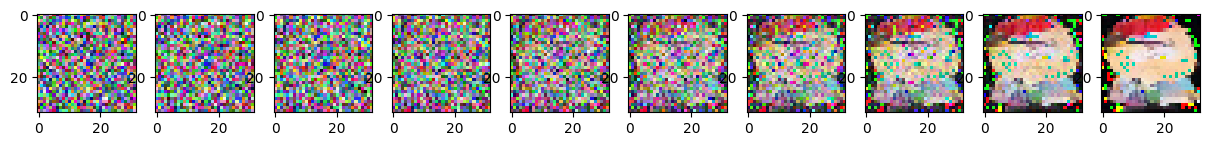

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.37it/s]


Epoch 42 | Train Loss: 860.3968023506485


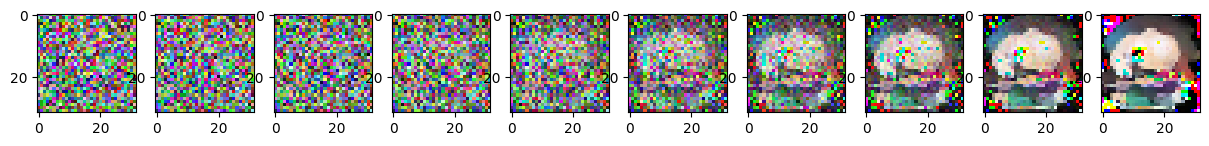

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.53it/s]


Epoch 43 | Train Loss: 900.2933244515729


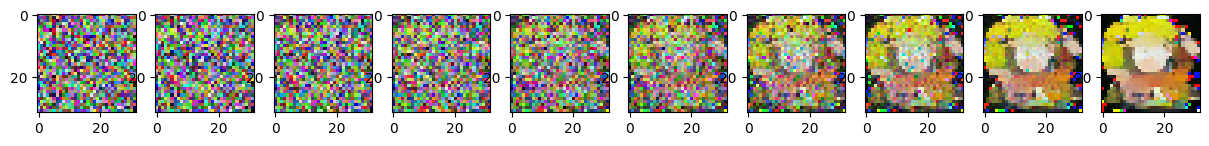

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.79it/s]


Epoch 44 | Train Loss: 874.2115626724614


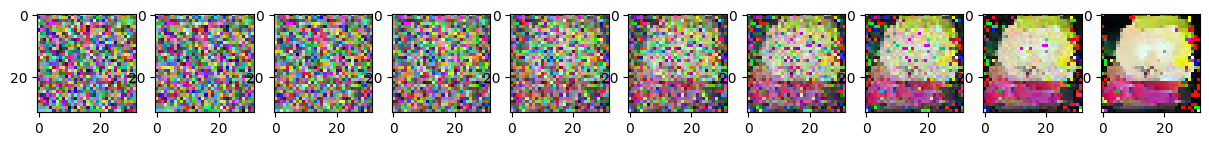

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.38it/s]


Epoch 45 | Train Loss: 885.4541576124448


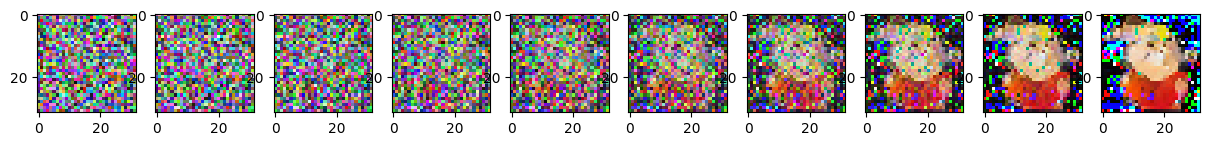

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.37it/s]


Epoch 46 | Train Loss: 858.0942134899283


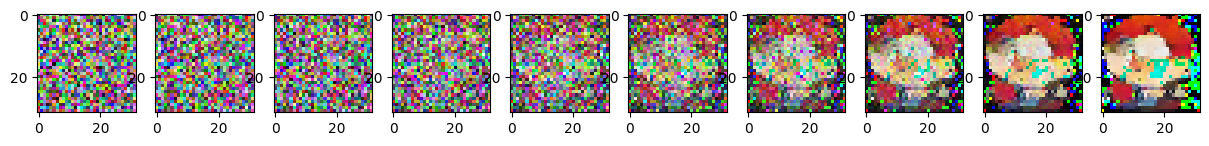

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.27it/s]


Epoch 47 | Train Loss: 846.4374698192605


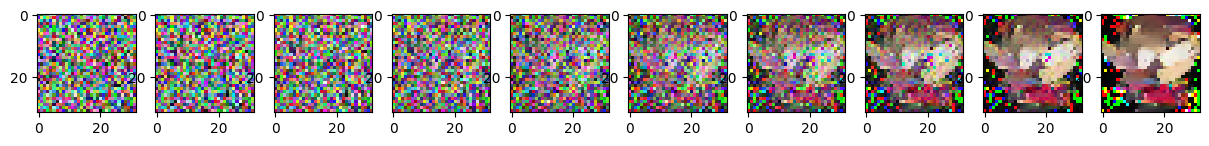

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.26it/s]


Epoch 48 | Train Loss: 852.5682386520419


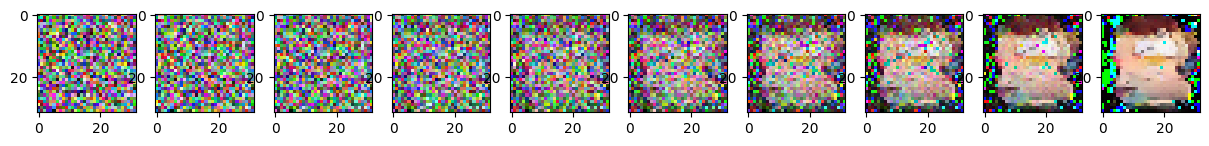

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.56it/s]


Epoch 49 | Train Loss: 844.0329670685016


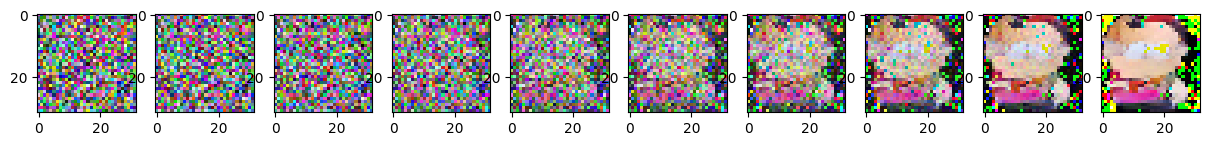

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.94it/s]


Epoch 50 | Train Loss: 865.6457859064569


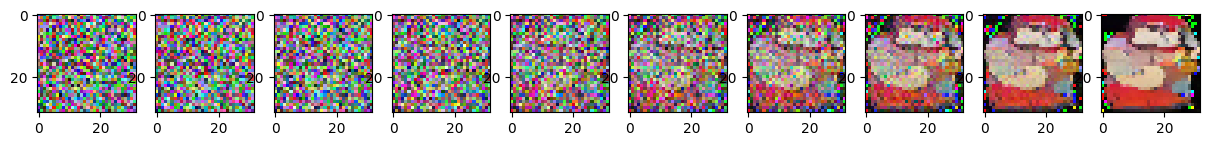

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.47it/s]


Epoch 51 | Train Loss: 857.8766038907285


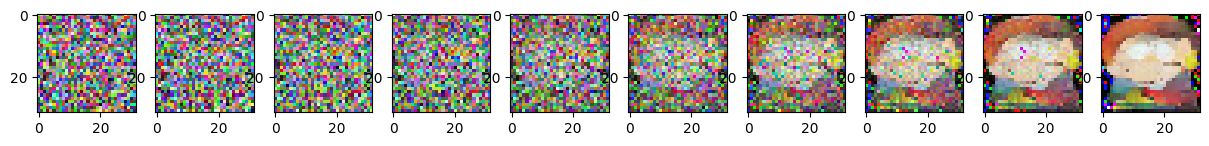

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.68it/s]


Epoch 52 | Train Loss: 862.9788314448814


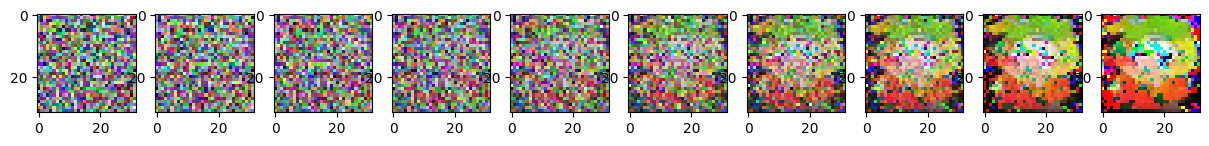

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.61it/s]


Epoch 53 | Train Loss: 862.6414970077952


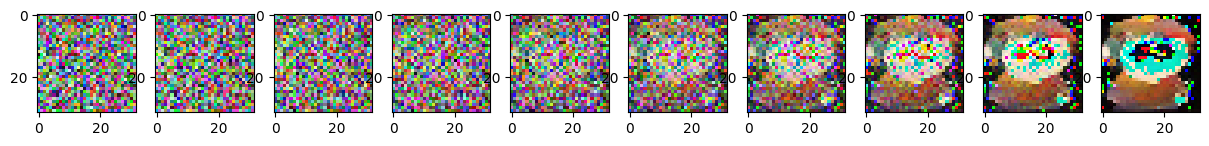

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.04it/s]


Epoch 54 | Train Loss: 843.7733943846579


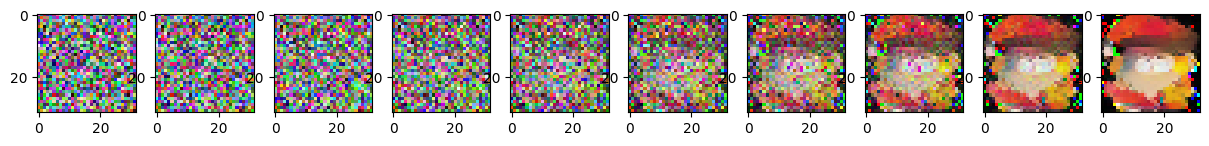

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.30it/s]


Epoch 55 | Train Loss: 819.3543154145972


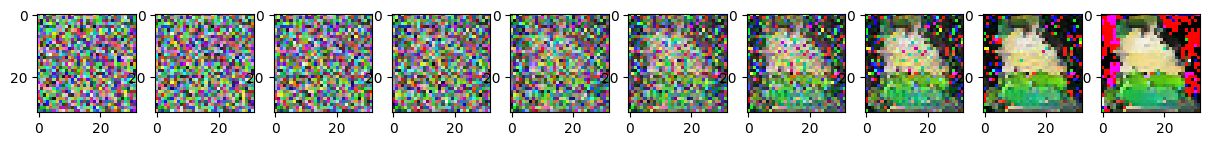

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.35it/s]


Epoch 56 | Train Loss: 844.6148172340646


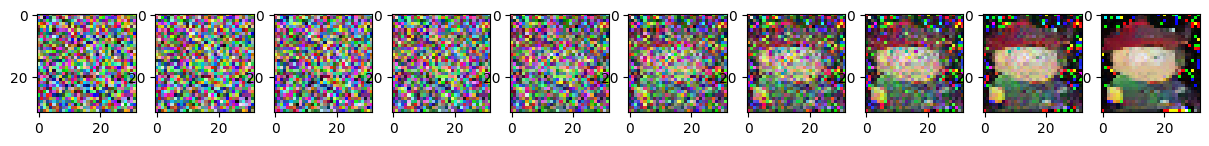

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.43it/s]


Epoch 57 | Train Loss: 852.8969909802704


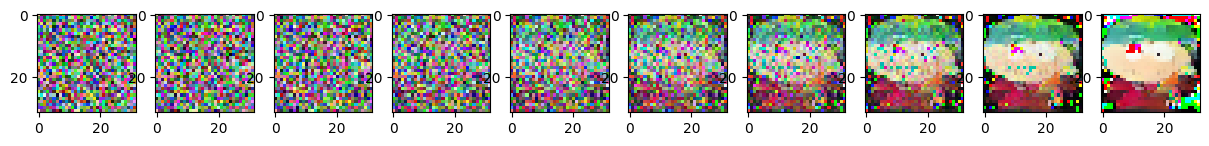

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.31it/s]


Epoch 58 | Train Loss: 847.0018248568571


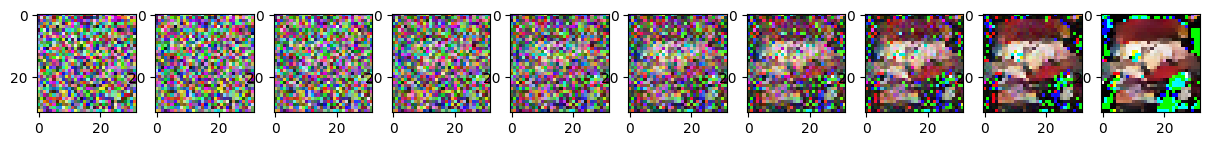

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.14it/s]


Epoch 59 | Train Loss: 839.2094209178395


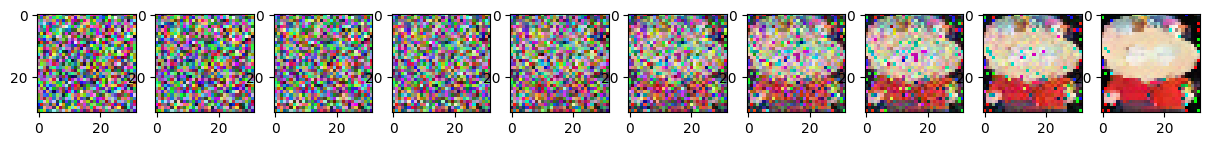

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.93it/s]


Epoch 60 | Train Loss: 839.9983077228201


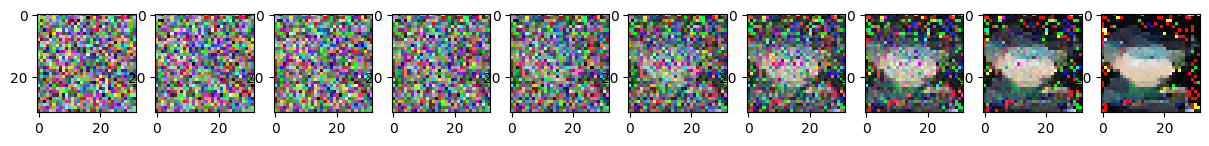

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.60it/s]


Epoch 61 | Train Loss: 844.5115506001656


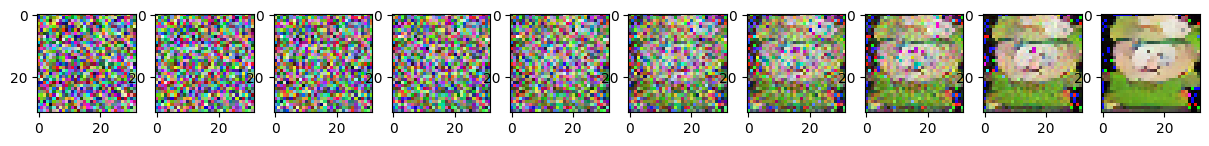

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.27it/s]


Epoch 62 | Train Loss: 835.122418468888


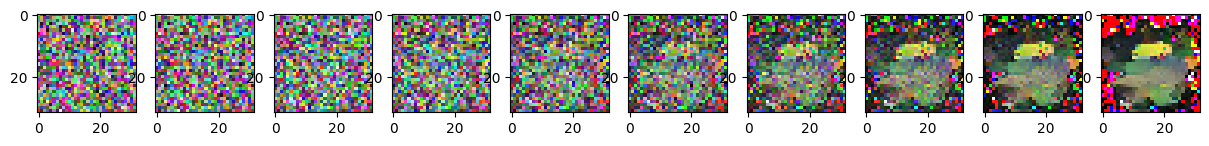

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.43it/s]


Epoch 63 | Train Loss: 849.6091971492136


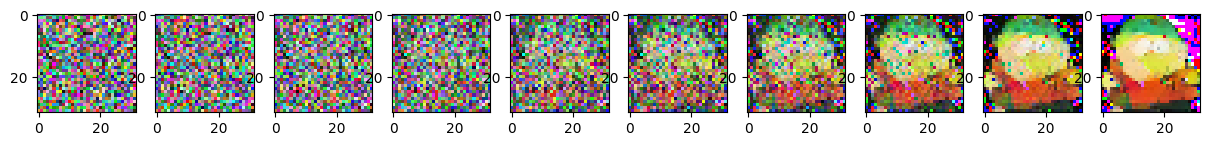

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.78it/s]


Epoch 64 | Train Loss: 820.0590464610927


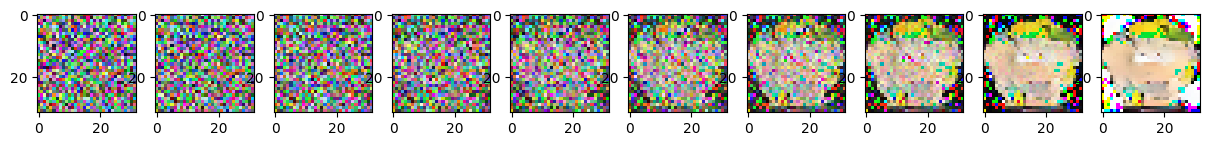

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.97it/s]


Epoch 65 | Train Loss: 821.9663236841197


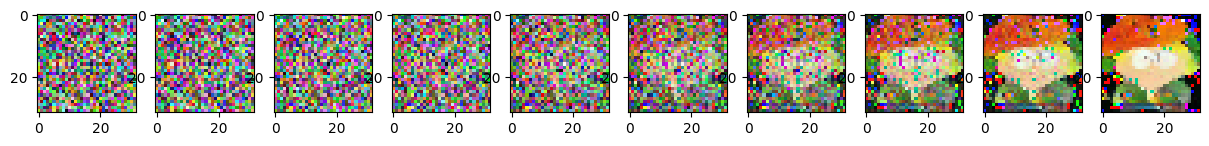

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.97it/s]


Epoch 66 | Train Loss: 806.9161029335679


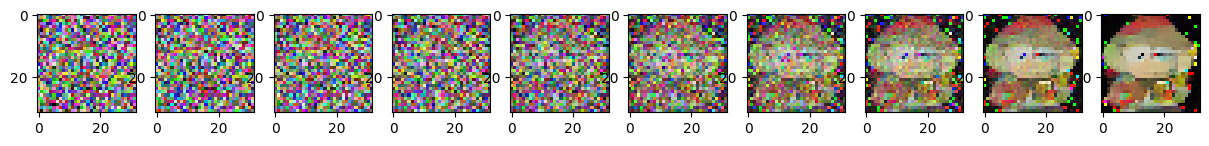

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.49it/s]


Epoch 67 | Train Loss: 832.8082294253587


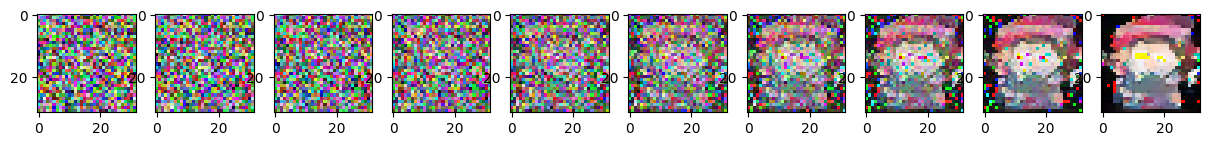

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 18.21it/s]


Epoch 68 | Train Loss: 822.6791949072158


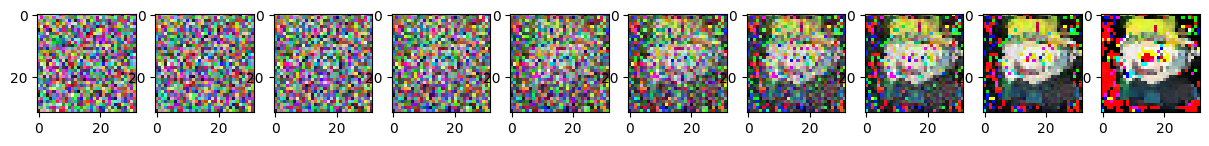

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.48it/s]


Epoch 69 | Train Loss: 811.433335057947


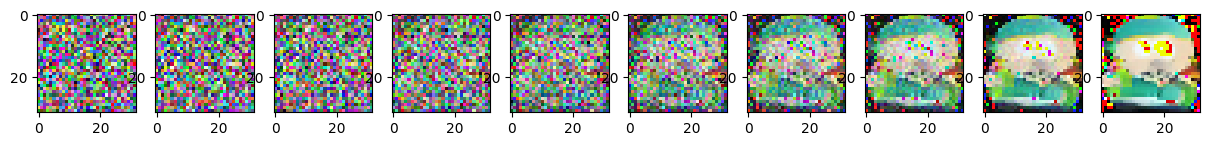

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.30it/s]


Epoch 70 | Train Loss: 805.268585946123


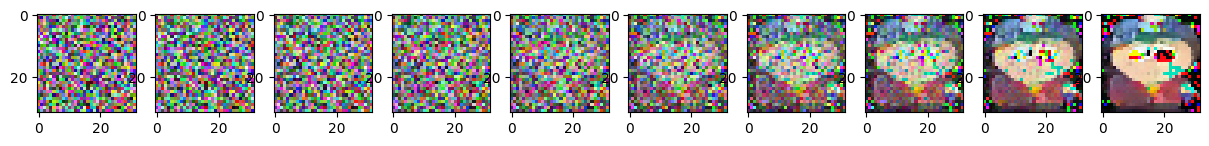

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.76it/s]


Epoch 71 | Train Loss: 790.7615333540286


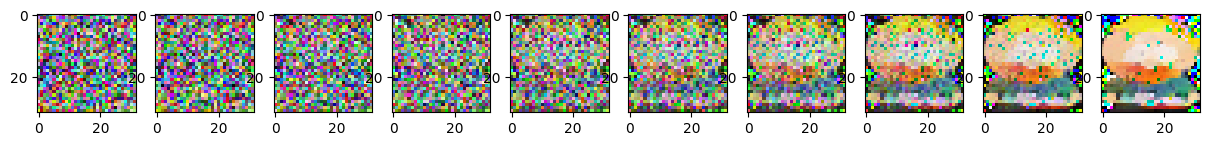

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.08it/s]


Epoch 72 | Train Loss: 797.5696916390729


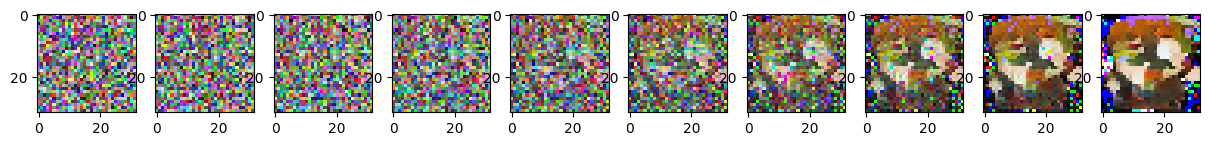

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.44it/s]


Epoch 73 | Train Loss: 792.8099163131209


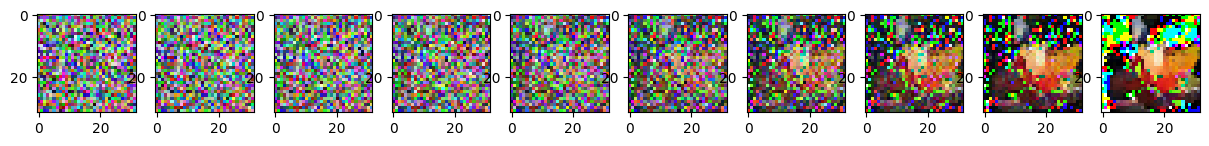

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.14it/s]


Epoch 74 | Train Loss: 811.3527729632312


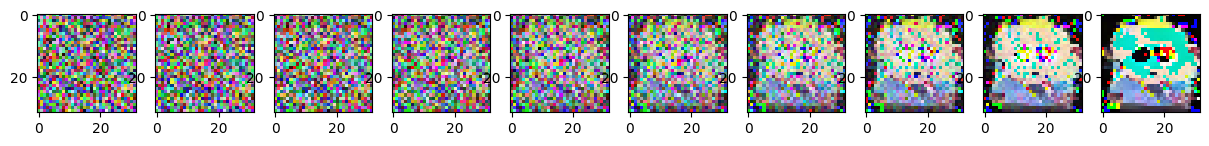

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.92it/s]


Epoch 75 | Train Loss: 843.3505676134796


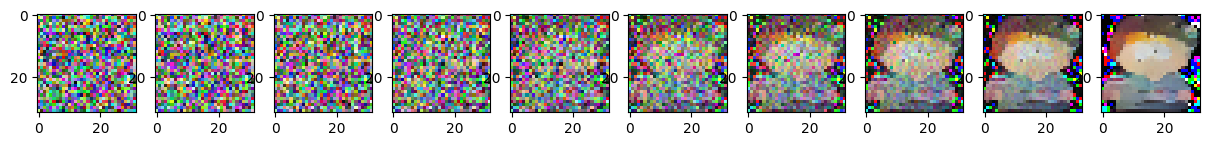

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.60it/s]


Epoch 76 | Train Loss: 786.4432688327814


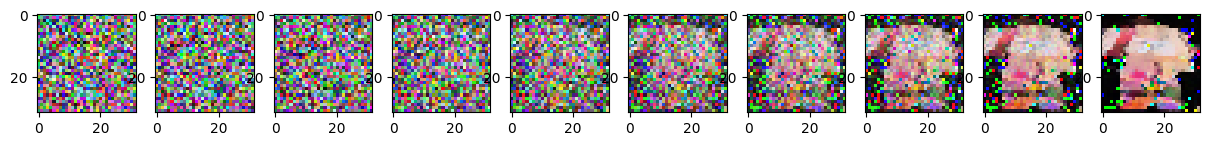

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.84it/s]


Epoch 77 | Train Loss: 796.3337709540563


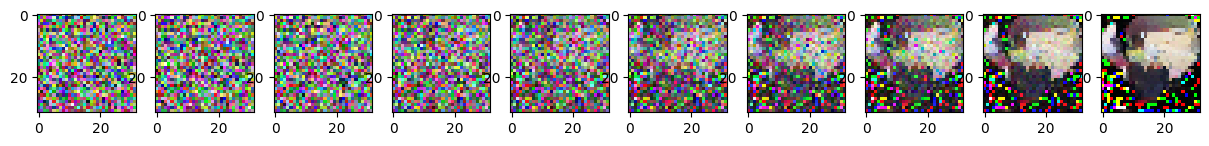

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.17it/s]


Epoch 78 | Train Loss: 813.7024351545253


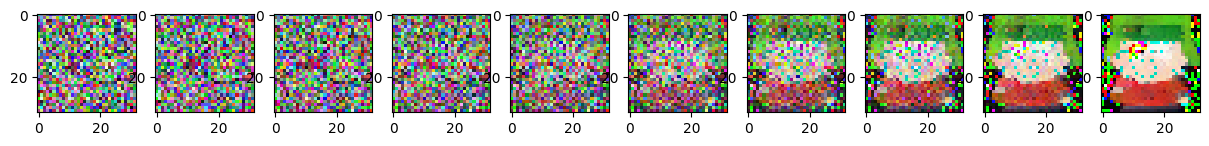

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.07it/s]


Epoch 79 | Train Loss: 801.9486657957367


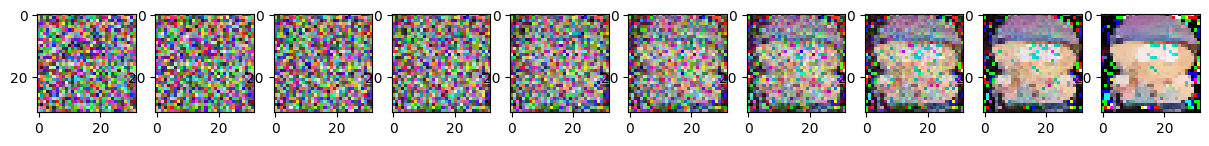

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.01it/s]


Epoch 80 | Train Loss: 776.4680288959023


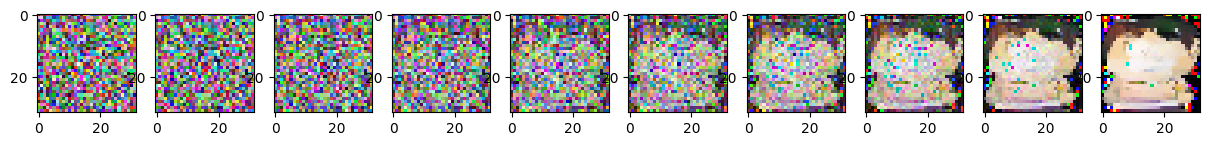

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.66it/s]


Epoch 81 | Train Loss: 806.0183304877207


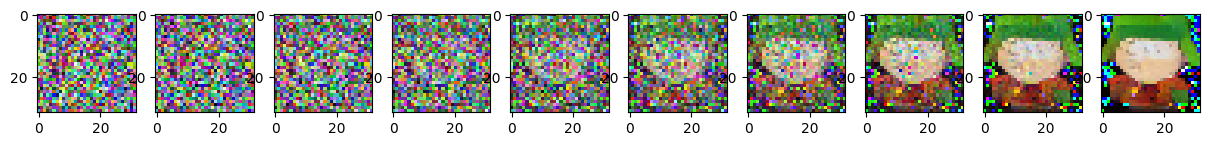

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.54it/s]


Epoch 82 | Train Loss: 805.6647092301324


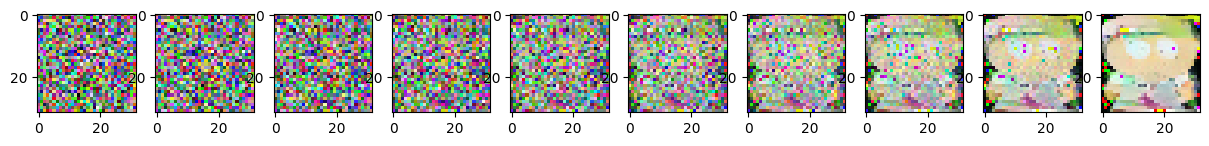

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.45it/s]


Epoch 83 | Train Loss: 779.759209437086


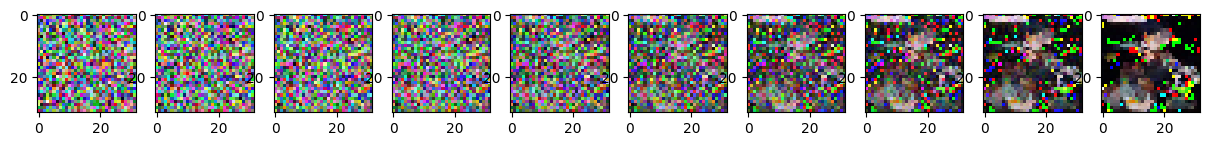

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.00it/s]


Epoch 84 | Train Loss: 776.5726267159906


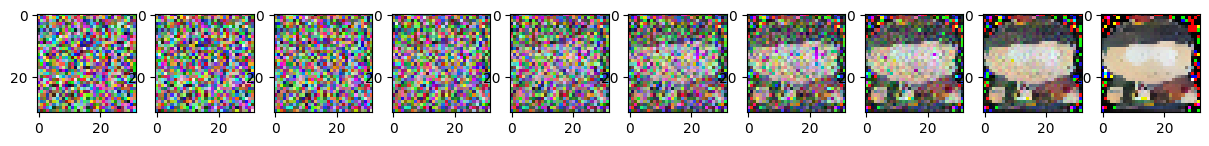

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.42it/s]


Epoch 85 | Train Loss: 791.9151942777318


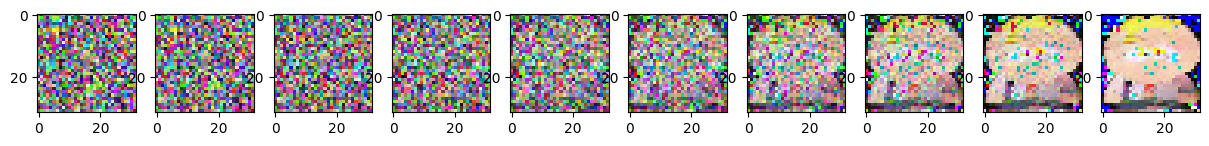

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.33it/s]


Epoch 86 | Train Loss: 791.001346276559


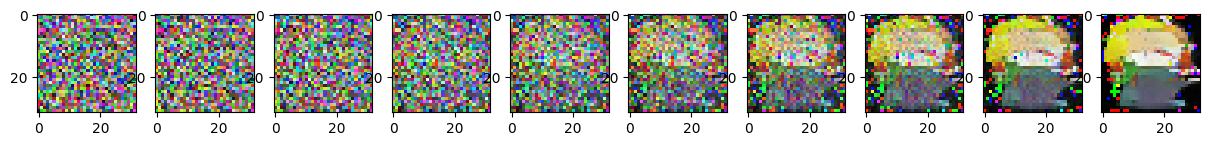

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.25it/s]


Epoch 87 | Train Loss: 785.1746699520558


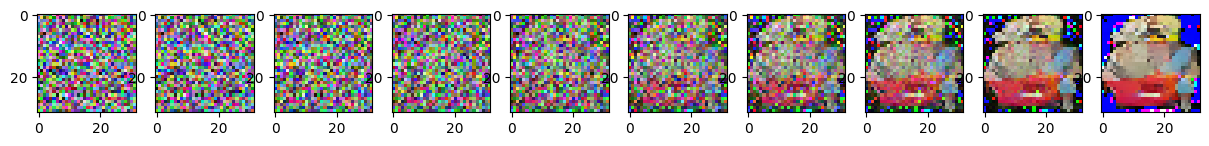

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.84it/s]


Epoch 88 | Train Loss: 772.6905202297186


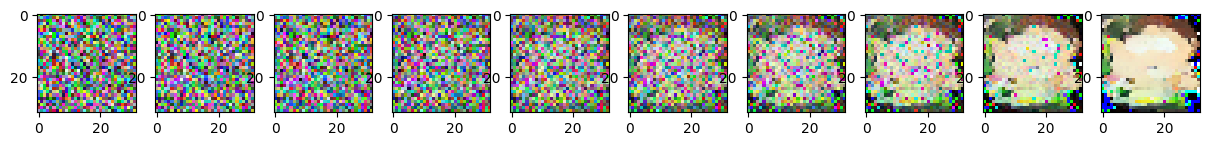

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.45it/s]


Epoch 89 | Train Loss: 764.9412844491584


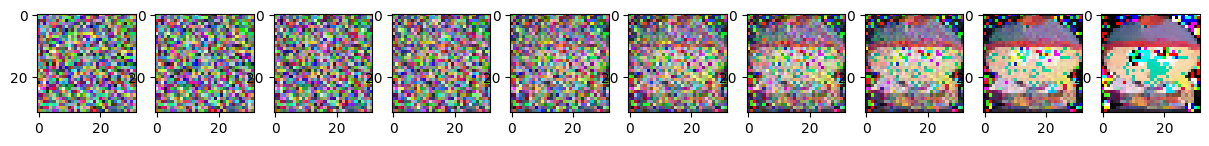

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.03it/s]


Epoch 90 | Train Loss: 769.5920512555188


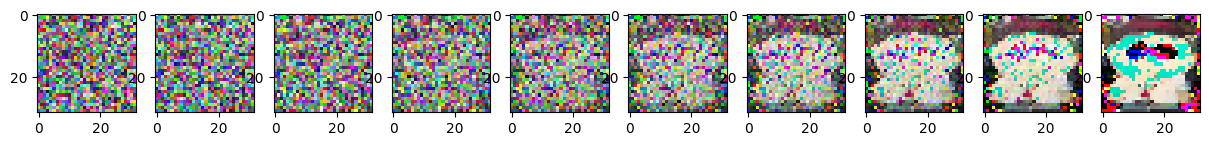

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.39it/s]


Epoch 91 | Train Loss: 759.0278212524145


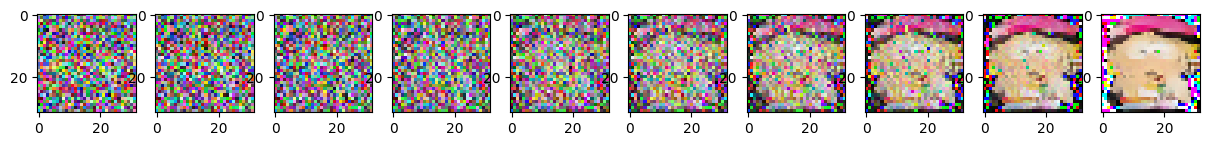

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.96it/s]


Epoch 92 | Train Loss: 755.1532728856237


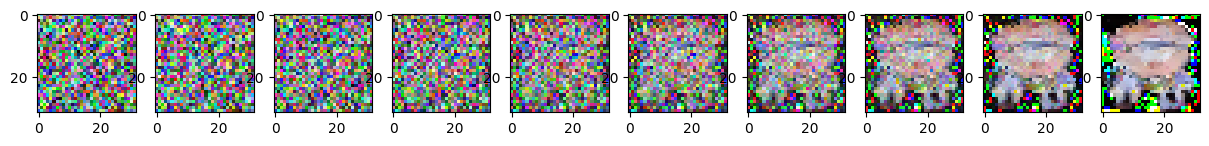

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.02it/s]


Epoch 93 | Train Loss: 789.4913305825745


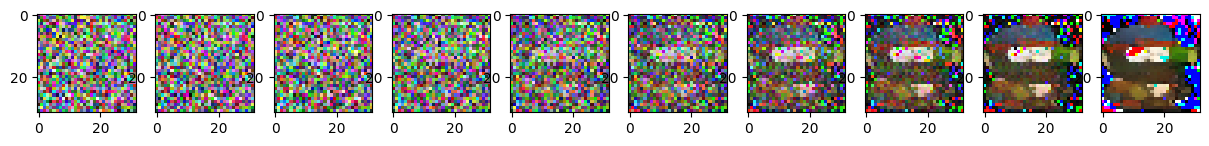

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.38it/s]


Epoch 94 | Train Loss: 777.7781079694398


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.87it/s]


Epoch 95 | Train Loss: 781.8540696571469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.80it/s]


Epoch 96 | Train Loss: 775.0492711351408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.55it/s]


Epoch 97 | Train Loss: 771.7001338731374


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.32it/s]


Epoch 98 | Train Loss: 765.0306140487031


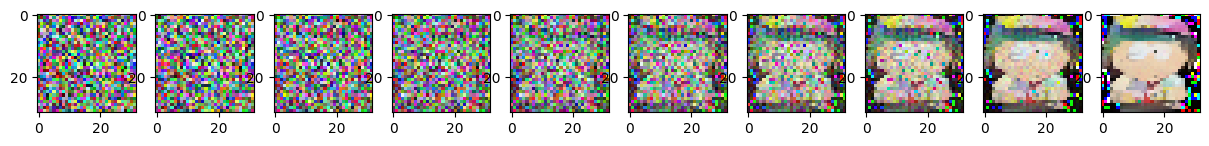

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.47it/s]


Epoch 99 | Train Loss: 791.6547140159354


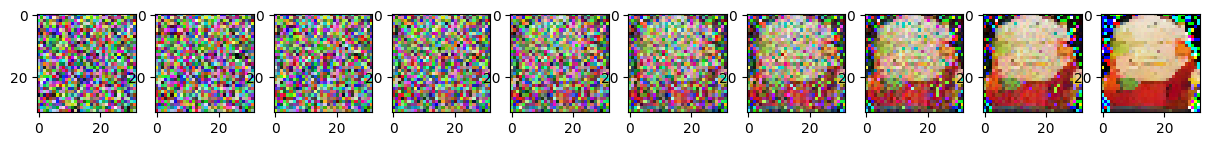

In [13]:
from torch.optim import Adam
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 100 # Try more!

for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, device)
    # eval_loss = eval_epoch(model, test_dataloader, device)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss}")
        
        euler_integration(model, torch.tensor(np.random.normal(size=[3, 32, 32]), dtype=torch.float32).to(device).unsqueeze(0))
        